In [1]:
import numpy as np
import torch

from framework.boundedManifold import BoundedManifold
from typing import List, Tuple, Union, Callable


/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
def visualize_manifold_curvature_with_geodesic(manifold,
                                               grid,
                                               p0: Union[torch.Tensor, np.ndarray],
                                               p1: Union[torch.Tensor, np.ndarray],
                                               z_range: Union[Tuple[float, float], torch.Tensor, None] = None,
                                               resolution: int = 30,
                                               data_points: Union[torch.Tensor, None] = None,
                                               labels: Union[torch.Tensor, None] = None,
                                               h_curvature: float = 1e-3,
                                               exact_mode: bool = False,
                                               max_nodes_to_plot: int = 20000,
                                               pathfinding_workers: int = 4,
                                               use_processes_for_pathfinding: bool = False,
                                               approx_samples_for_line: int = 256,
                                               show_progress: bool = False):
    """
    Combined visualization:
      - left: 2D curvature heatmap (as in your original method) WITH overlays:
          * grid nodes (subsampled if many)
          * data_points (if provided)
          * discrete geodesic path computed via GridGraph Dijkstra
          * straight-line (sampled) for comparison
      - middle: 3D surface of curvature
      - right: contour plot of curvature

    Arguments:
      - grid: GridGraph instance (must be 2D grid)
      - p0, p1: endpoints for geodesic (array-like or torch.Tensor), must lie inside manifold bounds
      - other args: same semantics as your original curvature function
    Returns:
      dict with keys: 'path_indices', 'path_positions', 'path_geodesic_length', 'straight_euclidean_length', 'straight_geodesic_approx'
    """
    if manifold.get_dimension() != 2:
        raise ValueError("Curvature visualization is supported only for 2D manifolds.")
    if grid.n_dims != 2:
        raise ValueError("Grid must be 2D for geodesic overlay (grid.n_dims must be 2).")

    device = manifold.device if hasattr(manifold, "device") else grid.device

    # Ensure p0/p1 are torch tensors on device
    p0_t = torch.as_tensor(p0, dtype=torch.get_default_dtype(), device=device).float().view(-1)
    p1_t = torch.as_tensor(p1, dtype=torch.get_default_dtype(), device=device).float().view(-1)

    # check bounds
    pts = torch.stack([p0_t, p1_t], dim=0)
    if not manifold._is_within_bounds(pts).all():
        raise ValueError("One or both query points are outside the manifold bounds.")

    # --- compute curvature grid (identical logic to original) ---
    with torch.no_grad():
        if z_range is None:
            bounds_np = manifold.get_bounds().cpu().numpy()
            plot_z1 = np.linspace(bounds_np[0, 0], bounds_np[0, 1], resolution)
            plot_z2 = np.linspace(bounds_np[1, 0], bounds_np[1, 1], resolution)
        else:
            if isinstance(z_range, torch.Tensor):
                zr = z_range.cpu().numpy()
            elif isinstance(z_range, (list, tuple)) and len(z_range) == 2 and isinstance(z_range[0], (list, tuple, np.ndarray)):
                # allow passing explicit mesh arrays
                plot_z1 = np.asarray(z_range[0])
                plot_z2 = np.asarray(z_range[1])
            else:
                # assume a 2-tuple specifying global bounds (unlikely given your signature)
                bounds_np = manifold.get_bounds().cpu().numpy()
                plot_z1 = np.linspace(bounds_np[0, 0], bounds_np[0, 1], resolution)
                plot_z2 = np.linspace(bounds_np[1, 0], bounds_np[1, 1], resolution)

        Z1_np, Z2_np = np.meshgrid(plot_z1, plot_z2)
        # convert to torch for computation
        Z1 = torch.from_numpy(Z1_np).to(device)
        Z2 = torch.from_numpy(Z2_np).to(device)

        curvature = torch.zeros((resolution, resolution), device=device)

        # compute curvature grid (loop small resolution, keep your behavior)
        for i in range(resolution):
            for j in range(resolution):
                z = torch.stack([Z1[i, j], Z2[i, j]])
                try:
                    clamped_z = manifold._clamp_point_to_bounds(z)
                    if exact_mode:
                        curv_val = manifold.compute_true_gaussian_curvature(clamped_z, h=h_curvature)
                        curvature[i, j] = torch.log(curv_val + 1e-8)
                    else:
                        curv_val = manifold.compute_gaussian_curvature(manifold.metric_tensor(clamped_z))
                        curvature[i, j] = curv_val
                except (ValueError, RuntimeError) as e:
                    # keep NaN for bad points
                    curvature[i, j] = torch.nan

        curvature_np = curvature.cpu().numpy()

    # --- Prepare figure with three panels (left heatmap will receive overlays) ---
    fig = plt.figure(figsize=(18, 6))

    # color normalization and colormap selection (same logic as before)
    vmin, vmax = np.nanmin(curvature_np), np.nanmax(curvature_np)
    if np.isnan(vmin) or np.isnan(vmax) or vmin == vmax:
        vmin, vmax = -1.0, 1.0
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    if vmin < 0 and vmax > 0:
        cmap = 'RdBu_r'
    elif vmin < 0 and vmax <= 0:
        cmap = 'Blues_r'
    else:
        cmap = 'Reds'

    # Left: 2D curvature heatmap
    ax1 = fig.add_subplot(131)
    im = ax1.pcolormesh(Z1_np, Z2_np, curvature_np, cmap=cmap, norm=norm, shading='auto')
    ax1.set_title('Manifold Gaussian Curvature (2D View)')
    cbar = plt.colorbar(im, ax=ax1, label='Curvature')

    # Overlay grid nodes (subsample if too many)
    node_pos = grid.node_positions.cpu().numpy()  # (N, 2)
    n_nodes = node_pos.shape[0]
    #if n_nodes <= max_nodes_to_plot:
    #    ax1.scatter(node_pos[:, 0], node_pos[:, 1], s=8, color="#cccccc", alpha=0.6, zorder=1, label="Grid nodes")
    #else:
    #    rng = np.random.default_rng(0)
    #    idx = rng.choice(n_nodes, size=max_nodes_to_plot, replace=False)
    #    ax1.scatter(node_pos[idx, 0], node_pos[idx, 1], s=6, color="#e6e6e6", alpha=0.6, zorder=1,
    #                label=f"Grid nodes (subset {max_nodes_to_plot})")

    # Overlay external data points if provided
    if data_points is not None:
        dp_np = data_points.detach().cpu().numpy()
        lab_np = labels.detach().cpu().numpy() if labels is not None else None
        if lab_np is not None:
            ax1.scatter(dp_np[:, 0], dp_np[:, 1], c=lab_np, cmap='viridis', edgecolors='k', s=50, zorder=4, label='Data points')
        else:
            ax1.scatter(dp_np[:, 0], dp_np[:, 1], color='#444444', edgecolors='k', s=50, zorder=4, label='Data points')

    # --- compute discrete geodesic path via GridGraph (uses your precomputation + pathfinding) ---
    # Build extended graph and run pathfinding (threaded by default — safe for notebooks)
    with torch.no_grad():
        # Reuse same show_progress flag for internal stages; keep it off by default
        graph_info = grid._build_extended_graph_structure(torch.stack([p0_t, p1_t], dim=0),
                                                          connection_radius=None,
                                                          max_grid_neighbors=8,
                                                          show_progress=show_progress)
        # safer to use threads in interactive contexts
        paths = grid._find_shortest_paths_parallel(graph_info, 2,
                                                  workers=pathfinding_workers or 4,
                                                  use_processes=use_processes_for_pathfinding)

    path = paths.get((0, 1), None)
    path_positions = None
    path_length = None
    straight_euc = float(torch.norm(p1_t - p0_t).item())
    straight_geo_approx = None

    if path is not None:
        all_pos_np = graph_info['all_positions'].cpu().numpy()
        path_positions = all_pos_np[path]  # (L, 2)
        # overlay discrete path
        ax1.plot(path_positions[:, 0], path_positions[:, 1],
                 marker='o', markersize=6, linestyle='-', linewidth=3, color="#D43F3A",
                 label='Discrete geodesic (Dijkstra)', zorder=6)
        ax1.scatter(path_positions[0:1, 0], path_positions[0:1, 1], s=90, marker='*', color="#2a9df4", zorder=7, label='Start')
        ax1.scatter(path_positions[-1:, 0], path_positions[-1:, 1], s=90, marker='X', color="#0b6623", zorder=7, label='Goal')

        # compute discrete geodesic length (batched if possible)
        try:
            path_pos_t = torch.tensor(path_positions, device=device, dtype=grid.node_positions.dtype)
            if path_pos_t.shape[0] > 1:
                seg_a = path_pos_t[:-1]
                seg_b = path_pos_t[1:]
                seg_w = grid._compute_geodesic_weight(seg_a, seg_b)
                path_length = float(seg_w.sum().item())
            else:
                path_length = 0.0
        except Exception:
            # fallback to euclidean sums
            path_length = float(np.linalg.norm(path_positions[1:] - path_positions[:-1], axis=1).sum()) if path_positions.shape[0] > 1 else 0.0

        # straight-line sampled points for plotting and approximate geodesic along straight line
        S = max(2, int(approx_samples_for_line))
        t = torch.linspace(0.0, 1.0, steps=S, device=device, dtype=grid.node_positions.dtype)
        line_pts = p0_t.unsqueeze(0) * (1 - t).unsqueeze(1) + p1_t.unsqueeze(0) * t.unsqueeze(1)
        try:
            geo_seg = grid._compute_geodesic_weight(line_pts[:-1], line_pts[1:])
            straight_geo_approx = float(geo_seg.sum().item())
        except Exception:
            straight_geo_approx = float(torch.norm(line_pts[1:] - line_pts[:-1], dim=1).sum().item())

        # overlay straight sampled line
        line_np = line_pts.cpu().numpy()
        ax1.plot(line_np[:, 0], line_np[:, 1], linestyle='--', linewidth=2.5, color="#2a9df4", alpha=0.85, label='Straight line (sampled)', zorder=5)
    else:
        ax1.text(0.02, 0.98, 'No discrete path found', transform=ax1.transAxes,
                 fontsize=10, color='red', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    # Finalize left panel aesthetics
    ax1.set_aspect('equal', adjustable='box')
    ax1.grid(alpha=0.25)

    # Middle: 3D surface
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(Z1_np, Z2_np, curvature_np, cmap=cmap, norm=norm)
    ax2.set_title('Manifold Gaussian Curvature (3D Surface)')

    # Right: contour
    ax3 = fig.add_subplot(133)
    contour = ax3.contourf(Z1_np, Z2_np, curvature_np, 20, cmap=cmap, norm=norm)
    ax3.set_title('Manifold Gaussian Curvature (Contour)')
    plt.colorbar(contour, ax=ax3, label='Curvature')

    # also scatter data points on right contour if provided
    if data_points is not None:
        dp_np = data_points.detach().cpu().numpy()
        lab_np = labels.detach().cpu().numpy() if labels is not None else None
        if lab_np is not None:
            ax3.scatter(dp_np[:, 0], dp_np[:, 1], c=lab_np, cmap='viridis', edgecolors='k')
        else:
            ax3.scatter(dp_np[:, 0], dp_np[:, 1], color='#444444', edgecolors='k')

    # Title summarizing lengths
    length_summary = []
    if path_length is not None:
        length_summary.append(f"Discrete geodesic: {path_length:.4f}")
    length_summary.append(f"Straight Euclidean: {straight_euc:.4f}")
    if straight_geo_approx is not None:
        length_summary.append(f"Straight geo approx: {straight_geo_approx:.4f}")
    ax1.set_title(" | ".join(length_summary), fontsize=10)

    # Legend (combine handles)
    ax1.legend(loc='best', fontsize=9)

    plt.tight_layout()
    plt.show()

    return {
        'path_indices': path,
        'path_positions': path_positions,
        'path_geodesic_length': path_length,
        'straight_euclidean_length': straight_euc,
        'straight_geodesic_approx': straight_geo_approx
    }

In [3]:
def gaussian_bump_metric(z: np.ndarray) -> np.ndarray:
    """
    Metric with Gaussian-shaped distortion: g = (1 + α*exp(-|z|²/σ²))I
    Creates a region of high curvature around the origin.

    Args:
        z: A 1D or 2D PyTorch Tensor representing a point, e.g., torch.tensor([x, y])
           or a batch of points. For a single 2D point, it should have shape (2,)
           or (1, 2). The metric is designed for R^2, so the last dimension
           is assumed to be 2.

    Returns:
        A PyTorch Tensor representing the metric tensor g.
        If z is (2,), returns a (2, 2) tensor.
        If z is (N, 2), returns a (N, 2, 2) tensor.
    """
    # Define parameters (can be made input arguments if needed)
    alpha = 2000.0  # Strength of distortion
    sigma = 0.15  # Width of distortion

    # Ensure z is at least 2D for batched operations if a single point (2,) is passed
    if z.dim() == 1:
        # Assume it's a single point (2,) and reshape to (1, 2) for consistency
        z_reshaped = z.unsqueeze(0)
    else:
        # Assume (N, 2) or (1, 2)
        z_reshaped = z

    # Calculate squared radius: |z|^2 = x^2 + y^2
    # torch.pow(z_reshaped, 2) -> (N, 2)
    # torch.sum(..., dim=-1) -> (N,)
    r_squared = torch.sum(torch.pow(z_reshaped, 2), dim=-1)

    # Calculate the scalar factor
    # torch.pow(sigma, 2) is sigma**2
    factor = 1.0 + alpha * torch.exp(-r_squared / (sigma**2))  # Shape (N,)

    # Create the identity matrix I for R^2 (2x2)
    I = torch.eye(2, dtype=z.dtype, device=z.device) # Shape (2, 2)

    # The metric tensor g is factor * I
    # If factor is (N,), we unsqueeze it to (N, 1, 1) and use broadcasting
    # (N, 1, 1) * (2, 2) -> (N, 2, 2)

    if z.dim() == 1:
        # If the input was (2,), return (2, 2)
        return factor.squeeze() * I
    else:
        # If the input was (N, 2), return (N, 2, 2)
        return factor.unsqueeze(-1).unsqueeze(-1) * I

In [4]:
testBM = BoundedManifold(gaussian_bump_metric, bounds=torch.tensor([[-1.5,1.5], [-1.5,1.5]]), grid_size=50)

In [5]:
gaussian_bump_metric(torch.tensor([[0.1, 0.1]]))

tensor([[[823.2245,   0.0000],
         [  0.0000, 823.2245]]])

In [6]:
testBM.compute_full_grid_metric_tensor()

Computing metric tensors for 2601 grid points...


Grid compute: 100%|██████████| 2601/2601 [00:00<00:00, 19225.62it/s]

Completed. Cached 2601 / 2601 points.


Building adjacency (original edges):   0%|          | 0/10100 [00:00<?, ?it/s]

Query->Grid connections:   0%|          | 0/2 [00:00<?, ?it/s]

Query->Query connections: 0it [00:00, ?it/s]

Pathfinding (Threaded Dijkstra):   0%|          | 0/2 [00:00<?, ?it/s]

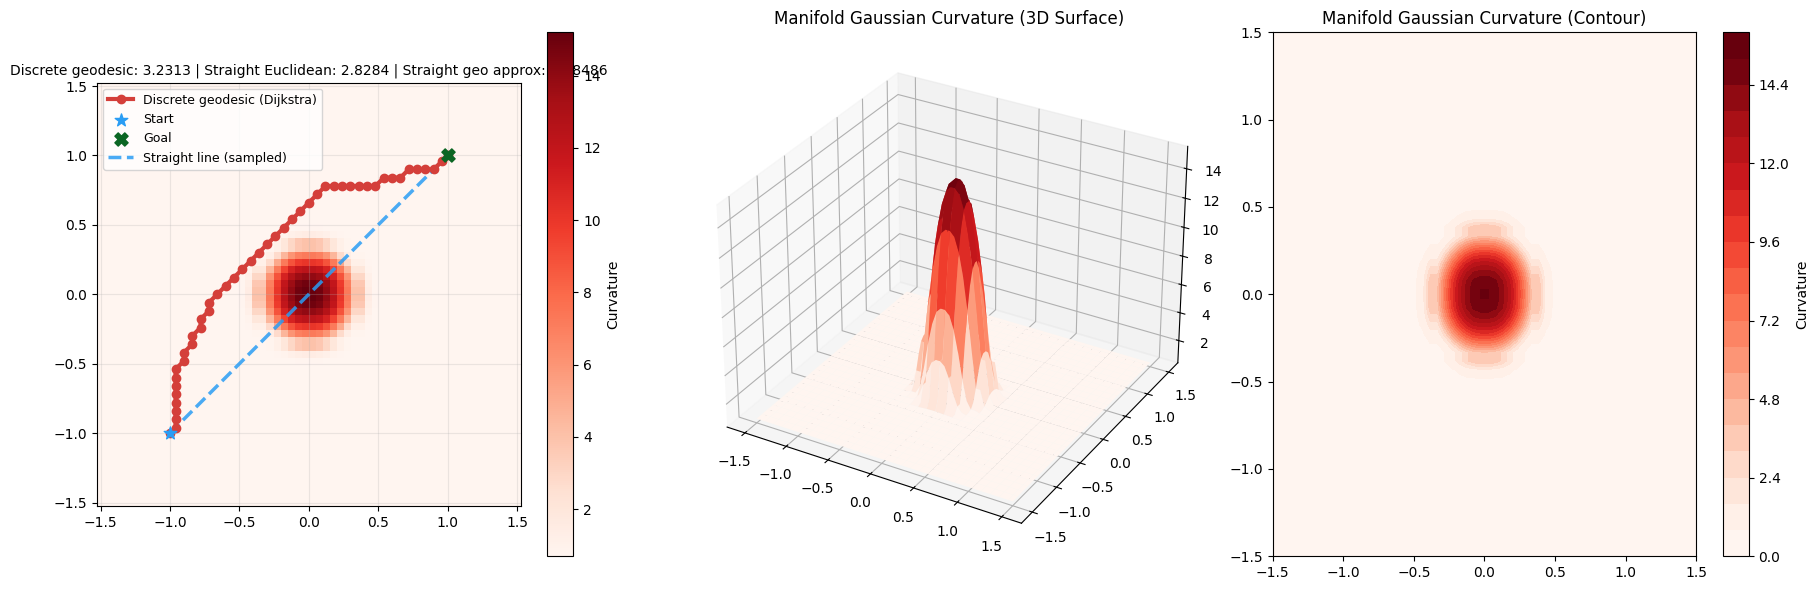

{'path_indices': [2601,
  468,
  469,
  470,
  471,
  472,
  473,
  474,
  475,
  527,
  528,
  580,
  581,
  633,
  634,
  686,
  687,
  739,
  791,
  843,
  895,
  947,
  999,
  1051,
  1103,
  1155,
  1207,
  1259,
  1311,
  1363,
  1415,
  1466,
  1517,
  1568,
  1619,
  1670,
  1721,
  1773,
  1824,
  1875,
  1927,
  1978,
  2029,
  2080,
  2132,
  2602],
 'path_positions': array([[-1.        , -1.        ],
        [-0.96000004, -0.96000004],
        [-0.96000004, -0.90000004],
        [-0.96000004, -0.84000003],
        [-0.96000004, -0.78000003],
        [-0.96000004, -0.72      ],
        [-0.96000004, -0.66      ],
        [-0.96000004, -0.6       ],
        [-0.96000004, -0.54      ],
        [-0.90000004, -0.48000002],
        [-0.90000004, -0.42000008],
        [-0.84000003, -0.36      ],
        [-0.84000003, -0.30000007],
        [-0.78000003, -0.24000001],
        [-0.78000003, -0.18000007],
        [-0.72      , -0.12      ],
        [-0.72      , -0.06000006],
       

In [7]:
visualize_manifold_curvature_with_geodesic(testBM,
                            grid=testBM.get_grid_as_graph(), p0=torch.tensor([-1,-1]), p1=torch.tensor([1,1]),
                            approx_samples_for_line=526,
                            show_progress=True,
                            resolution=60)

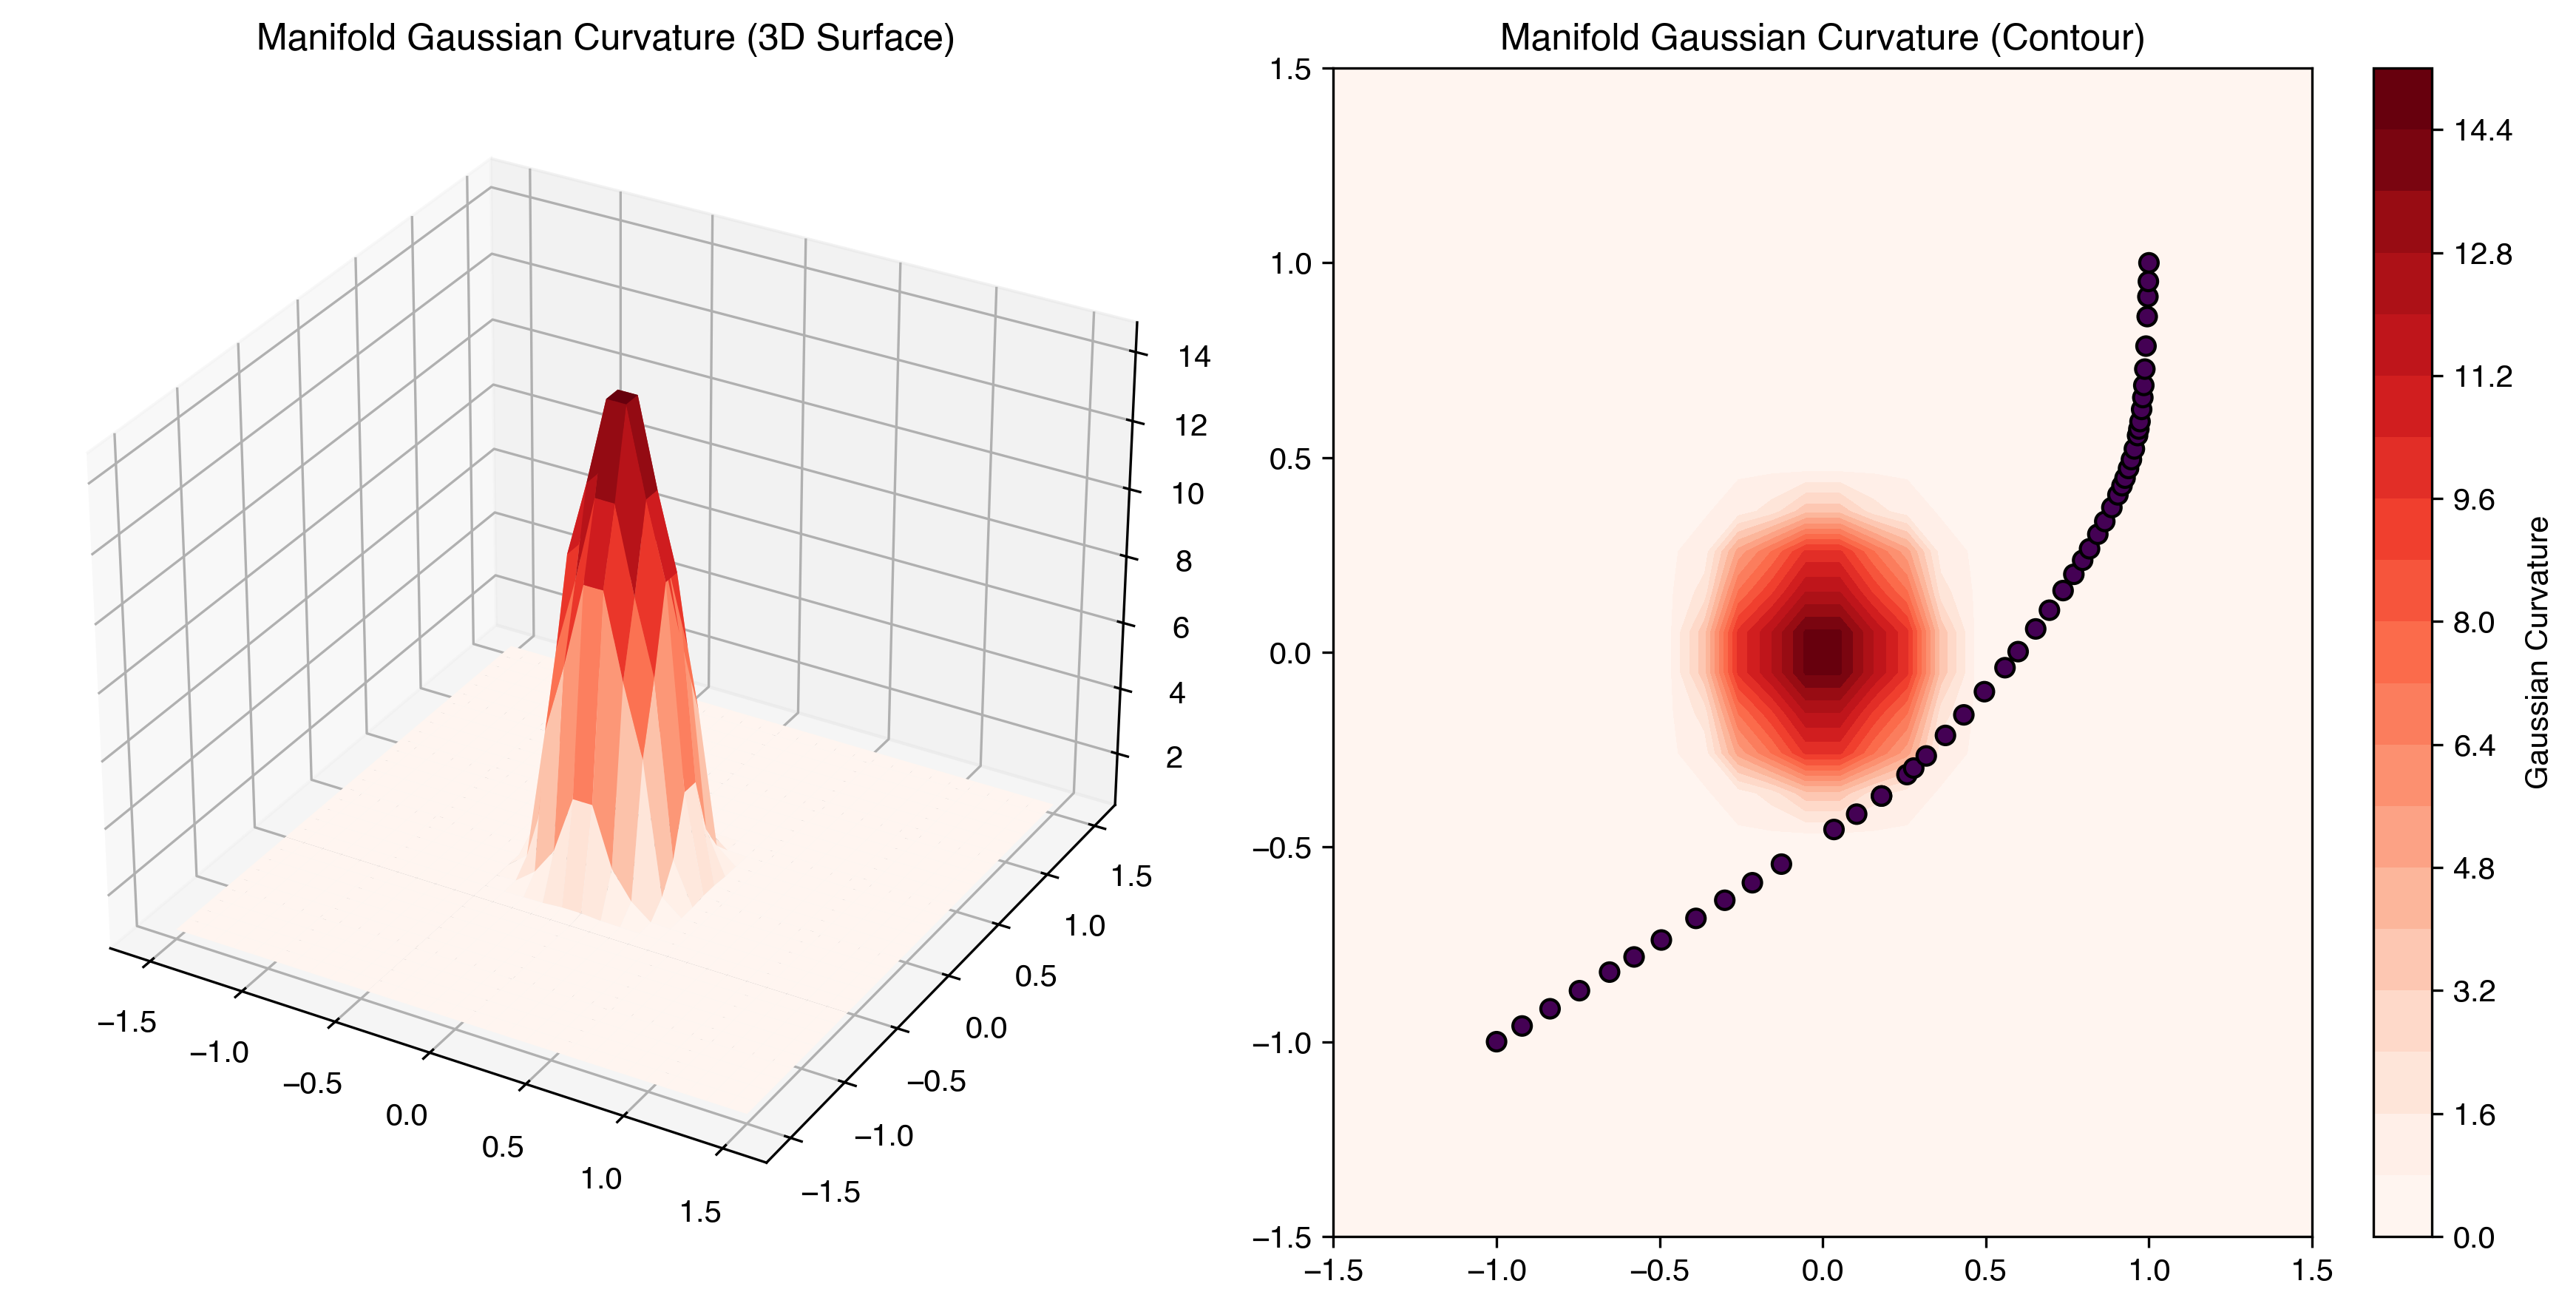

tensor(3.1483)


In [8]:
geo_points = testBM.compute_geodesic(torch.tensor([-1,-1]), torch.tensor([1,1]), num_points=50)
testBM.visualize_manifold_curvature(data_points=geo_points[0])
print(geo_points[1]) 